In [1]:
%load_ext autoreload
%autoreload 2
from glob import glob
from torch.utils.data import DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
from tqdm import tqdm
from monai.data import CacheDataset, Dataset, list_data_collate
from monai.transforms import (
    AsChannelFirstd,
    AddChanneld,
    AsDiscreted,
    Compose,
    CropForegroundd,
    EnsureChannelFirstd,
    LoadImaged,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    RandRotated,
    RandZoomd,
    Rotated,
    ScaleIntensityd,
    ScaleIntensityRanged,
    Transposed,
    EnsureTyped,
    RandAffined,
    Transform,
    MapTransform,
    RandGibbsNoised,
    RandKSpaceSpikeNoised,
    RandGaussianNoised,
    RandCoarseDropoutd,
    ResizeWithPadOrCropd,
    RandSpatialCropd,
    Lambdad
)

# ensure is in parent directory
try:
    print(os.getcwd())
    os.chdir("../../rug-hr/")
    print(os.getcwd())
except:
    pass

## Experiment setup

In [2]:
SPATIAL_SIZE = [128, 1024]
MODEL_OUTPUT_NAME = "x".join([str(x) for x in SPATIAL_SIZE])
MODEL_OUTPUT_NAME = f"unetr-{MODEL_OUTPUT_NAME}-masked-lm.pt"
config = {
    "epochs": 200,
    "batch_size": 12,
    "learning_rate": 1e-4,
    "architecture": "UNETR",
    "dataset": "handwitten_manuscripts",
    "spatial_size": SPATIAL_SIZE,
    "splits": [0.88, 0.08],
    "model_output_name": MODEL_OUTPUT_NAME,
    "name": "IAM handwriting recognition",
    "description": "Masked language model for handwriting recognition",
    "pretrained_model": MODEL_OUTPUT_NAME,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
}

In [3]:
import wandb 
def init_experiment(config=config):
    wandb.init(
        project="handwriting-recognition-iam",
        config=config,
    )

def terminate_experiment():
    wandb.finish()

def log(data):
    wandb.log(data)

## Data setup

Some notes:
- Max height: 342; Max width: 2260
- Min height: 44; Min width: 100
- Mean height: 121.56060606060606; Mean width: 1693.719093590775
- Max tokens: 27

In [4]:
dataset_name = config["dataset"]
segs = glob(f"./datasets/{dataset_name}/Raw/*")
imgs = glob(f"./datasets/{dataset_name}/Mutated/*")
fraction = 1

metadata = [{
    "img": p_img, 
    "seg": p_seg, 
} for p_img, p_seg in zip(imgs, segs)]

random.shuffle(metadata)
metadata = metadata[:int(len(metadata) * fraction)]

# split into training, validation and test set
split_train = int(len(metadata) * config["splits"][0])
split_validation = int(len(metadata) * (config["splits"][1] + config["splits"][0]))

train_metadata = metadata[:split_train]
validation_metadata = metadata[split_train:split_validation]
test_metadata = metadata[split_validation:]

print(f"Train: {len(train_metadata)}; Validation: {len(validation_metadata)}; Test: {len(test_metadata)}")
print(f"Example: {train_metadata[0]}")
n_classes = ord("~") - ord(" ") + 1
print(f"Number of classes: {n_classes}")

Train: 23254; Validation: 2114; Test: 1057
Example: {'img': './datasets/handwitten_manuscripts/Mutated\\41785_Lemon Tuesday_29.png', 'seg': './datasets/handwitten_manuscripts/Raw\\41785_Lemon Tuesday_29.png'}
Number of classes: 95


In [5]:

from monai.config import KeysCollection


class Invert(Transform):
    def __call__(self, data, max_value=1.0, min_value=0.0):
        return max_value - data + min_value

class Invertd(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)
        self.invert = Invert()

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key] = self.invert(d[key])
        return d
    
class AddMask(Transform):
    """ Adds a mask channel to the image where 
    Args: 
        prob: probability of zeroing out a region
        min_portion: minimum portion of the image to zero out in each dimension
        max_portion: maximum portion of the image to zero out in each dimension
    """
    def __init__(self, 
                 prob=0.5, 
                 min_portion=(0.1, 0.1), 
                 max_portion=(0.5, 0.5)):
        self.prob = prob
        self.min_portion = min_portion
        self.max_portion = max_portion
    
    """
    Args:
        image: (..., C, H, W)
    Returns: with mask channel added
        image: (..., C+1, H, W)
    """
    def __call__(self, image):
        C, H, W = image.shape[-3:]
        mask = torch.ones((*image.shape[:-3], 1, H, W))
        if random.random() < self.prob:
            min_p_i, min_p_j = self.min_portion
            max_p_i, max_p_j = self.max_portion
            p_i = random.uniform(min_p_i, max_p_i)
            p_j = random.uniform(min_p_j, max_p_j)
            size_i = int(H * p_i)
            size_j = int(W * p_j)
            i_start = random.randint(0, H - size_i)
            j_start = random.randint(0, W - size_j)
            i_end = i_start + size_i
            j_end = j_start + size_j   
            mask[..., i_start:i_end, j_start:j_end] = 0
        image *= mask
        return torch.cat([image, mask], dim=-3)
    
class AddMaskd(MapTransform):
    def __init__(self, keys: KeysCollection, allow_missing_keys: bool = False,  *argc, **argv) -> None:
        super().__init__(keys, allow_missing_keys)
        self.add_mask = AddMask(*argc, **argv)
    
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key] = self.add_mask(d[key])
        return d

augmentation_transforms = Compose([
    RandCoarseDropoutd(keys=["img"], holes=128, spatial_size=(8, 8), max_holes=128, fill_value=0, prob=0.5),
    RandGaussianNoised(keys=["img"], mean=0.0, std=0.02, prob=0.7),
    RandShiftIntensityd(keys=["img"], offsets=0.1, prob=0.5),
])

input_transforms = Compose([
    # Image transformations
    LoadImaged(keys=["img", "seg"]),
    AddChanneld(keys=["img", "seg"]),
    EnsureTyped(keys=["img", "seg"]),
    Transposed(keys=["img", "seg"], indices=[0, -1, -2]),
    CropForegroundd(keys=["img", "seg"], source_key="img", ),
    ResizeWithPadOrCropd(
        keys=["img", "seg"],
        spatial_size=(256, 2048),
        mode="constant",
    ),
    ScaleIntensityRanged(keys=["img"], a_min=0, a_max=1, b_min=0.0, b_max=1.0, clip=True),
    # Augmentation
    augmentation_transforms,
    # Post processing
    ScaleIntensityRanged(keys=["img"], a_min=0, a_max=1, b_min=0.0, b_max=1.0, clip=True),
    AddMaskd(
        keys=["img"], 
        prob=0.5, 
        min_portion=(0.8, 0.1), 
        max_portion=(0.9, 0.2),
    ),
    RandSpatialCropd(
        keys=["img", "seg"],
        roi_size=config["spatial_size"],
        random_size=False,
    ),
    Lambdad(keys=["seg"], func=lambda x: torch.clamp(x, 0, n_classes-1)),
    EnsureTyped(keys=["img", "seg"]),
])

train_transforms = Compose([
    input_transforms,
    EnsureTyped(keys=["img", "seg"]),
])

validation_transforms = Compose([
    input_transforms,
    EnsureTyped(keys=["img", "seg"]),
])


c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\monai\utils\deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


image: torch.Size([2, 128, 1024])
segmentation: torch.Size([1, 128, 1024])
range(img): (tensor(0.), tensor(1.))
range(img[1]): (tensor(1.), tensor(1.))
range(seg): (tensor(0.), tensor(87.))


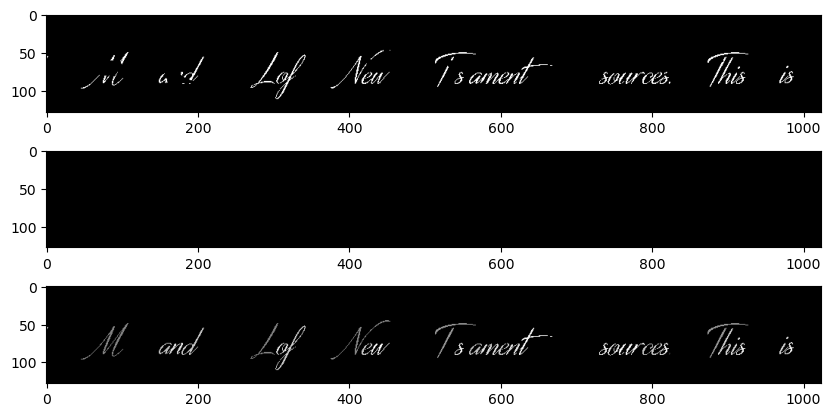

In [6]:

# example
choice = random.choice(train_metadata)
output = train_transforms(choice)
spatial_size = torch.zeros(config["spatial_size"]).shape
assert output["img"][0].shape == spatial_size or print(output["img"][0].shape, spatial_size)
assert output["seg"][0].shape == spatial_size or print(output["seg"][0].shape, spatial_size)
# ensuer seg is at max n_classes
assert output["seg"].max() < n_classes or print("wrong seg max", output["seg"].max())
assert output["seg"].min() >= 0 or print("wrong seg min", output["seg"].min())
assert output["img"].max() <= 1 or print("wrong img max", output["img"].max())
assert output["img"].min() >= 0 or print("wrong img min", output["img"].min())
assert output["img"].shape[0] == 2 or print(output["img"].shape)
assert output["seg"].shape[0] == 1 or print(output["seg"].shape)

 
print("image:", output["img"].shape)
print("segmentation:", output["seg"].shape)
print(f"range(img): ({output['img'].min()}, {output['img'].max()})")
print(f"range(img[1]): ({output['img'][1].min()}, {output['img'][1].max()})")
print(f"range(seg): ({output['seg'].min()}, {output['seg'].max()})")
fig, ax = plt.subplots(3, 1, figsize=(10, 5))
ax[0].imshow(output["img"][0], cmap="gray")
ax[1].imshow(output["img"][1], cmap="gray")
ax[2].imshow(output["seg"][0], cmap="gray")
plt.show()

In [7]:
train_dataset = CacheDataset(data=train_metadata, transform=train_transforms)
validation_dataset = CacheDataset(data=validation_metadata, transform=validation_transforms)
test_dataset = Dataset(data=test_metadata, transform=input_transforms)
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"])
validation_loader = DataLoader(validation_dataset, batch_size=config["batch_size"])
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"])

Loading dataset: 100%|██████████| 2114/2114 [00:00<00:00, 2112138.79it/s]


In [8]:

from modules.segnet import SEGNET
from monai.networks.nets import UNETR

print("device name", torch.cuda.get_device_name(0))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

model_output_name = config.get("model_output_name")

hidden_size = 768
model = UNETR(
    in_channels=2,
    out_channels=n_classes, 
    img_size=config["spatial_size"],
    feature_size=32,
    num_heads=12,
    hidden_size=hidden_size,
    mlp_dim=4*hidden_size,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.1,
    spatial_dims=2,
    conv_block=False
).to(device)

net = SEGNET(
    model_name=model_output_name,
    device=device, 
    load=False,
    model=model,
    img_size=config["spatial_size"],
    n_classes=n_classes,
)

pre_trained_model = config.get("pretrained_model", None)
if pre_trained_model:
    try:
        net.load_model("models/" + pre_trained_model)
        print("model loaded")
    except:
        print("could not load model")

# print number of trainable parameters
print("number of trainable parameters in millions:", sum(p.numel() for p in model.parameters() if p.requires_grad) / 1000000)
print("model size (MB)", sum(p.numel() for p in model.parameters() if p.requires_grad) * 4 / 1024 / 1024)

device name NVIDIA GeForce RTX 3090
model loaded
number of trainable parameters in millions: 90.785727
model size (MB) 346.32006454467773


In [9]:
init_experiment(config)

train_loss, test_loss, metrics = net.train(
    trainloader=train_loader, 
    valloader=validation_loader,
    log=log, 
    epochs=config.get("epochs"), 
    learning_rate=config.get("learning_rate"), 
    optimizer_name="adam", 
    schedule=False,
)

terminate_experiment()

2023-05-08 21:11:25,297 - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: massaf (rug-ai-group). Use `wandb login --relogin` to force relogin


epochs=200; N=23254; batches=1938; learning_rate=0.0001


100%|██████████| 1938/1938 [26:35<00:00,  1.22it/s]


epoch 1/200; train_loss=0.7666322780221362; test_loss=0.76973817476445; lr=0.0001; metric=0.6904822587966919


100%|██████████| 1938/1938 [24:38<00:00,  1.31it/s]


epoch 2/200; train_loss=0.7552913825332319; test_loss=0.7564911502229292; lr=0.0001; metric=0.707708477973938


100%|██████████| 1938/1938 [24:35<00:00,  1.31it/s]


epoch 3/200; train_loss=0.7464306080181409; test_loss=0.7481078606540874; lr=0.0001; metric=0.7220127582550049


100%|██████████| 1938/1938 [24:40<00:00,  1.31it/s]


epoch 4/200; train_loss=0.738940284563415; test_loss=0.7445803877324034; lr=0.0001; metric=0.7346430420875549


100%|██████████| 1938/1938 [24:37<00:00,  1.31it/s]


epoch 5/200; train_loss=0.7336976410680757; test_loss=0.7315993389840854; lr=0.0001; metric=0.7443357706069946


100%|██████████| 1938/1938 [24:40<00:00,  1.31it/s]


epoch 6/200; train_loss=0.7286532639965061; test_loss=0.7310072237488914; lr=0.0001; metric=0.7476382255554199


100%|██████████| 1938/1938 [24:35<00:00,  1.31it/s]


epoch 7/200; train_loss=0.7254943840889985; test_loss=0.7299030743076302; lr=0.0001; metric=0.749662458896637


100%|██████████| 1938/1938 [24:40<00:00,  1.31it/s]


epoch 8/200; train_loss=0.7228579235150718; test_loss=0.7215542608061752; lr=0.0001; metric=0.7668738961219788


100%|██████████| 1938/1938 [24:40<00:00,  1.31it/s]


epoch 9/200; train_loss=0.7185112864732496; test_loss=0.7182365521199285; lr=0.0001; metric=0.7659261226654053


100%|██████████| 1938/1938 [24:38<00:00,  1.31it/s]


epoch 10/200; train_loss=0.7143776056321167; test_loss=0.7167015813164792; lr=0.0001; metric=0.7663462162017822


100%|██████████| 1938/1938 [24:37<00:00,  1.31it/s]


epoch 11/200; train_loss=0.714735700127018; test_loss=0.7133043337676485; lr=0.0001; metric=0.7745589017868042


100%|██████████| 1938/1938 [24:41<00:00,  1.31it/s]


epoch 12/200; train_loss=0.711254193010222; test_loss=0.7114282247036864; lr=0.0001; metric=0.7769278287887573


100%|██████████| 1938/1938 [24:37<00:00,  1.31it/s]


epoch 13/200; train_loss=0.7086092444334728; test_loss=0.7080970547967038; lr=0.0001; metric=0.7825157046318054


100%|██████████| 1938/1938 [24:25<00:00,  1.32it/s]


epoch 14/200; train_loss=0.7070253547377139; test_loss=0.7103244881171965; lr=0.0001; metric=0.7868905067443848


100%|██████████| 1938/1938 [24:36<00:00,  1.31it/s]


epoch 15/200; train_loss=0.7059015015638035; test_loss=0.7030762649525357; lr=0.0001; metric=0.7902894616127014


100%|██████████| 1938/1938 [24:38<00:00,  1.31it/s]


epoch 16/200; train_loss=0.7038458179148112; test_loss=0.7042094179465945; lr=0.0001; metric=0.7910352945327759


100%|██████████| 1938/1938 [24:29<00:00,  1.32it/s]


epoch 17/200; train_loss=0.7014684191798278; test_loss=0.7023224561227916; lr=0.0001; metric=0.7971621751785278


100%|██████████| 1938/1938 [24:23<00:00,  1.32it/s]


epoch 18/200; train_loss=0.7007010062720138; test_loss=0.6999355854287659; lr=0.0001; metric=0.7951622009277344


100%|██████████| 1938/1938 [24:36<00:00,  1.31it/s]


epoch 19/200; train_loss=0.6989341755892593; test_loss=0.7029157311229383; lr=0.0001; metric=0.7950901389122009


100%|██████████| 1938/1938 [24:39<00:00,  1.31it/s]


epoch 20/200; train_loss=0.6974909829958058; test_loss=0.6996818434047161; lr=0.0001; metric=0.8023910522460938


100%|██████████| 1938/1938 [24:43<00:00,  1.31it/s]


epoch 21/200; train_loss=0.6972647964708331; test_loss=0.6979610724637737; lr=0.0001; metric=0.8028488159179688


100%|██████████| 1938/1938 [24:33<00:00,  1.32it/s]


epoch 22/200; train_loss=0.6853926473972844; test_loss=0.6906074447146917; lr=0.0001; metric=0.8042466640472412


100%|██████████| 1938/1938 [24:36<00:00,  1.31it/s]


epoch 23/200; train_loss=0.6842432539406452; test_loss=0.6811580674796455; lr=0.0001; metric=0.8107022047042847


100%|██████████| 1938/1938 [24:35<00:00,  1.31it/s]


epoch 24/200; train_loss=0.6833499342787499; test_loss=0.6796670822100451; lr=0.0001; metric=0.8107508420944214


100%|██████████| 1938/1938 [24:36<00:00,  1.31it/s]


epoch 25/200; train_loss=0.682992853770192; test_loss=0.6817509565649733; lr=0.0001; metric=0.8082793951034546


100%|██████████| 1938/1938 [24:33<00:00,  1.31it/s]


epoch 26/200; train_loss=0.6810051864945359; test_loss=0.6861250131143688; lr=0.0001; metric=0.8068379759788513


100%|██████████| 1938/1938 [24:39<00:00,  1.31it/s]


epoch 27/200; train_loss=0.6813855971160688; test_loss=0.6827247519951082; lr=0.0001; metric=0.8085495233535767


100%|██████████| 1938/1938 [24:44<00:00,  1.31it/s]


epoch 28/200; train_loss=0.6798028566396889; test_loss=0.6783589478266441; lr=0.0001; metric=0.8145022392272949


100%|██████████| 1938/1938 [24:29<00:00,  1.32it/s]


epoch 29/200; train_loss=0.6775705319501544; test_loss=0.6798749471788352; lr=0.0001; metric=0.8150264024734497


100%|██████████| 1938/1938 [24:32<00:00,  1.32it/s]


epoch 30/200; train_loss=0.6770635264146193; test_loss=0.6810627913070937; lr=0.0001; metric=0.8160901665687561


100%|██████████| 1938/1938 [24:35<00:00,  1.31it/s]


epoch 31/200; train_loss=0.6773472482759517; test_loss=0.682562196995579; lr=0.0001; metric=0.8109716773033142


100%|██████████| 1938/1938 [24:35<00:00,  1.31it/s]


epoch 32/200; train_loss=0.6721875489496225; test_loss=0.6779658817975535; lr=0.0001; metric=0.8199057579040527


100%|██████████| 1938/1938 [24:33<00:00,  1.32it/s]


epoch 33/200; train_loss=0.6590876142860567; test_loss=0.6630441889924518; lr=0.0001; metric=0.819916307926178


100%|██████████| 1938/1938 [24:30<00:00,  1.32it/s]


epoch 34/200; train_loss=0.6389463736269128; test_loss=0.6558332365784941; lr=0.0001; metric=0.8235354423522949


100%|██████████| 1938/1938 [24:35<00:00,  1.31it/s]


epoch 35/200; train_loss=0.43555479601287006; test_loss=0.5649470737424948; lr=0.0001; metric=0.7965582609176636


100%|██████████| 1938/1938 [24:34<00:00,  1.31it/s]


epoch 36/200; train_loss=0.3648136550228047; test_loss=0.38211300076737914; lr=0.0001; metric=0.7821155190467834


100%|██████████| 1938/1938 [25:14<00:00,  1.28it/s]


epoch 37/200; train_loss=0.3503430215459244; test_loss=0.36189954344835656; lr=0.0001; metric=0.7887373566627502


100%|██████████| 1938/1938 [25:08<00:00,  1.28it/s]


epoch 38/200; train_loss=0.34559836936778204; test_loss=0.34656021150492006; lr=0.0001; metric=0.7997514605522156


100%|██████████| 1938/1938 [24:54<00:00,  1.30it/s]


epoch 39/200; train_loss=0.340938004585304; test_loss=0.34532801175521594; lr=0.0001; metric=0.798865556716919


100%|██████████| 1938/1938 [24:24<00:00,  1.32it/s]


epoch 40/200; train_loss=0.33788908841963033; test_loss=0.3429990018491691; lr=0.0001; metric=0.7994025349617004


100%|██████████| 1938/1938 [24:26<00:00,  1.32it/s]


epoch 41/200; train_loss=0.33629438547865403; test_loss=0.3408470061202507; lr=0.0001; metric=0.8035993576049805


100%|██████████| 1938/1938 [24:25<00:00,  1.32it/s]


epoch 42/200; train_loss=0.339037753072624; test_loss=0.3412682632100111; lr=0.0001; metric=0.7993313074111938


100%|██████████| 1938/1938 [24:25<00:00,  1.32it/s]


epoch 43/200; train_loss=0.3323098538199322; test_loss=0.33184174747116824; lr=0.0001; metric=0.8070148825645447


100%|██████████| 1938/1938 [24:21<00:00,  1.33it/s]


epoch 44/200; train_loss=0.32983854090866044; test_loss=0.3353183190364622; lr=0.0001; metric=0.8045859932899475


100%|██████████| 1938/1938 [24:22<00:00,  1.33it/s]


epoch 45/200; train_loss=0.3312913324026501; test_loss=0.33286881850937666; lr=0.0001; metric=0.8045105934143066


100%|██████████| 1938/1938 [24:23<00:00,  1.32it/s]


epoch 46/200; train_loss=0.3286123779382253; test_loss=0.3358379455104386; lr=0.0001; metric=0.8063099384307861


100%|██████████| 1938/1938 [24:26<00:00,  1.32it/s]


epoch 47/200; train_loss=0.32591229009800526; test_loss=0.32943247629087524; lr=0.0001; metric=0.8108999729156494


100%|██████████| 1938/1938 [24:21<00:00,  1.33it/s]


epoch 48/200; train_loss=0.3259983292720266; test_loss=0.3315102548080649; lr=0.0001; metric=0.8084407448768616


100%|██████████| 1938/1938 [24:26<00:00,  1.32it/s]


epoch 49/200; train_loss=0.3238034347231789; test_loss=0.3282381874524941; lr=0.0001; metric=0.8096218705177307


100%|██████████| 1938/1938 [24:25<00:00,  1.32it/s]


epoch 50/200; train_loss=0.3241121556429179; test_loss=0.329007622464902; lr=0.0001; metric=0.8109725713729858


100%|██████████| 1938/1938 [24:27<00:00,  1.32it/s]


epoch 51/200; train_loss=0.3213743693257756; test_loss=0.3200177150425938; lr=0.0001; metric=0.8180779218673706


100%|██████████| 1938/1938 [24:26<00:00,  1.32it/s]


epoch 52/200; train_loss=0.3221204443551193; test_loss=0.327917955436949; lr=0.0001; metric=0.8126146793365479


100%|██████████| 1938/1938 [24:21<00:00,  1.33it/s]


epoch 53/200; train_loss=0.3195676508333661; test_loss=0.3236984601296948; lr=0.0001; metric=0.8140064477920532


100%|██████████| 1938/1938 [24:29<00:00,  1.32it/s]


epoch 54/200; train_loss=0.3190875563182329; test_loss=0.32965605466042536; lr=0.0001; metric=0.805809497833252


100%|██████████| 1938/1938 [24:30<00:00,  1.32it/s]


epoch 55/200; train_loss=0.31919478987976985; test_loss=0.32609305467646; lr=0.0001; metric=0.8109931349754333


100%|██████████| 1938/1938 [24:24<00:00,  1.32it/s]


epoch 56/200; train_loss=0.31972522059430525; test_loss=0.32397950057592767; lr=0.0001; metric=0.8164905309677124


100%|██████████| 1938/1938 [24:25<00:00,  1.32it/s]


epoch 57/200; train_loss=0.31689830091315774; test_loss=0.31922759654495003; lr=0.0001; metric=0.8187869787216187


100%|██████████| 1938/1938 [24:25<00:00,  1.32it/s]


epoch 58/200; train_loss=0.31660857793593433; test_loss=0.3217531754977285; lr=0.0001; metric=0.8131448030471802


100%|██████████| 1938/1938 [24:18<00:00,  1.33it/s]


epoch 59/200; train_loss=0.31714635546116393; test_loss=0.3216486563958691; lr=0.0001; metric=0.8182400465011597


100%|██████████| 1938/1938 [24:21<00:00,  1.33it/s]


epoch 60/200; train_loss=0.3151034269370408; test_loss=0.3227356611672094; lr=0.0001; metric=0.8158829808235168


100%|██████████| 1938/1938 [24:33<00:00,  1.31it/s]


epoch 61/200; train_loss=0.31253330335713025; test_loss=0.32149781539278516; lr=0.0001; metric=0.8196334838867188


100%|██████████| 1938/1938 [24:27<00:00,  1.32it/s]


epoch 62/200; train_loss=0.31457433224462505; test_loss=0.31972000971015563; lr=0.0001; metric=0.8139148950576782


100%|██████████| 1938/1938 [24:24<00:00,  1.32it/s]


epoch 63/200; train_loss=0.31182624521916125; test_loss=0.3214562048683059; lr=0.0001; metric=0.8150713443756104


100%|██████████| 1938/1938 [24:29<00:00,  1.32it/s]


epoch 64/200; train_loss=0.31214821020331546; test_loss=0.3142904117282501; lr=0.0001; metric=0.8219159841537476


100%|██████████| 1938/1938 [24:24<00:00,  1.32it/s]


epoch 65/200; train_loss=0.3111491467423114; test_loss=0.3240567806918742; lr=0.0001; metric=0.8150296211242676


100%|██████████| 1938/1938 [24:25<00:00,  1.32it/s]


epoch 66/200; train_loss=0.3112600742079033; test_loss=0.31872557263589846; lr=0.0001; metric=0.8213250637054443


100%|██████████| 1938/1938 [24:44<00:00,  1.31it/s]


epoch 67/200; train_loss=0.3090995395684882; test_loss=0.3158963943100245; lr=0.0001; metric=0.8227409720420837


100%|██████████| 1938/1938 [24:35<00:00,  1.31it/s]


epoch 68/200; train_loss=0.31059099544681634; test_loss=0.3228403790354055; lr=0.0001; metric=0.8166313171386719


100%|██████████| 1938/1938 [24:21<00:00,  1.33it/s]


epoch 69/200; train_loss=0.31033144931244533; test_loss=0.3210420857715068; lr=0.0001; metric=0.8152814507484436


100%|██████████| 1938/1938 [24:27<00:00,  1.32it/s]


epoch 70/200; train_loss=0.3089076109515009; test_loss=0.3199830196671567; lr=0.0001; metric=0.8159409761428833


100%|██████████| 1938/1938 [24:28<00:00,  1.32it/s]


epoch 71/200; train_loss=0.3083023114670049; test_loss=0.3138137483327402; lr=0.0001; metric=0.8260322213172913


100%|██████████| 1938/1938 [24:30<00:00,  1.32it/s]


epoch 72/200; train_loss=0.30811080302739413; test_loss=0.31414874832508927; lr=0.0001; metric=0.8263298869132996


100%|██████████| 1938/1938 [24:28<00:00,  1.32it/s]


epoch 73/200; train_loss=0.30530845799836087; test_loss=0.316787718884689; lr=0.0001; metric=0.8203855752944946


100%|██████████| 1938/1938 [24:29<00:00,  1.32it/s]


epoch 74/200; train_loss=0.30586873297075; test_loss=0.3169096620742884; lr=0.0001; metric=0.8224524855613708


100%|██████████| 1938/1938 [24:31<00:00,  1.32it/s]


epoch 75/200; train_loss=0.3075364968432854; test_loss=0.3141258276451779; lr=0.0001; metric=0.8263931274414062


100%|██████████| 1938/1938 [24:35<00:00,  1.31it/s]


epoch 76/200; train_loss=0.3063490544556341; test_loss=0.31657983943567436; lr=0.0001; metric=0.823519229888916


100%|██████████| 1938/1938 [24:26<00:00,  1.32it/s]


epoch 77/200; train_loss=0.3057619221470058; test_loss=0.3150826759931058; lr=0.0001; metric=0.822052001953125


100%|██████████| 1938/1938 [24:29<00:00,  1.32it/s]


epoch 78/200; train_loss=0.3046150628027532; test_loss=0.3190565190072787; lr=0.0001; metric=0.8216103911399841


100%|██████████| 1938/1938 [25:19<00:00,  1.28it/s]


epoch 79/200; train_loss=0.3044022396437524; test_loss=0.31679667768168585; lr=0.0001; metric=0.8191769123077393


100%|██████████| 1938/1938 [25:31<00:00,  1.27it/s]


epoch 80/200; train_loss=0.30415954886790525; test_loss=0.3200398605253737; lr=0.0001; metric=0.8181295394897461


100%|██████████| 1938/1938 [25:24<00:00,  1.27it/s]


epoch 81/200; train_loss=0.30370480588745896; test_loss=0.3183170010646184; lr=0.0001; metric=0.8164576292037964


100%|██████████| 1938/1938 [25:24<00:00,  1.27it/s]


epoch 82/200; train_loss=0.30322696428488405; test_loss=0.3166600808417056; lr=0.0001; metric=0.8196364641189575


100%|██████████| 1938/1938 [25:30<00:00,  1.27it/s]


epoch 83/200; train_loss=0.3030033654872601; test_loss=0.3124115915790116; lr=0.0001; metric=0.8285680413246155


100%|██████████| 1938/1938 [25:47<00:00,  1.25it/s]


epoch 84/200; train_loss=0.3025870773599121; test_loss=0.3137839375916174; lr=0.0001; metric=0.8239779472351074


100%|██████████| 1938/1938 [25:41<00:00,  1.26it/s]


epoch 85/200; train_loss=0.301370731248329; test_loss=0.31420531498510285; lr=0.0001; metric=0.8190266489982605


100%|██████████| 1938/1938 [25:25<00:00,  1.27it/s]


epoch 86/200; train_loss=0.3022088973760851; test_loss=0.30848606848447335; lr=0.0001; metric=0.8278582692146301


100%|██████████| 1938/1938 [25:34<00:00,  1.26it/s]


epoch 87/200; train_loss=0.3022992071091083; test_loss=0.32020571230158296; lr=0.0001; metric=0.8225014209747314


100%|██████████| 1938/1938 [25:31<00:00,  1.27it/s]


epoch 88/200; train_loss=0.3014349152167761; test_loss=0.328815787693875; lr=0.0001; metric=0.8031305074691772


100%|██████████| 1938/1938 [25:18<00:00,  1.28it/s]


epoch 89/200; train_loss=0.2891523217238386; test_loss=0.3124970972201245; lr=0.0001; metric=0.8268070816993713


100%|██████████| 1938/1938 [25:27<00:00,  1.27it/s]


epoch 90/200; train_loss=0.2646554898090038; test_loss=0.2909373180509287; lr=0.0001; metric=0.8167591691017151


100%|██████████| 1938/1938 [25:56<00:00,  1.24it/s]


epoch 91/200; train_loss=0.2596286735867445; test_loss=0.2820192668902672; lr=0.0001; metric=0.8137356042861938


100%|██████████| 1938/1938 [25:43<00:00,  1.26it/s]


epoch 92/200; train_loss=0.25737579782773096; test_loss=0.2787318076454314; lr=0.0001; metric=0.8154776096343994


100%|██████████| 1938/1938 [25:20<00:00,  1.27it/s]


epoch 93/200; train_loss=0.256656427370813; test_loss=0.27268453186514685; lr=0.0001; metric=0.8204595446586609


100%|██████████| 1938/1938 [25:40<00:00,  1.26it/s]


epoch 94/200; train_loss=0.25489829716698426; test_loss=0.26661453795971846; lr=0.0001; metric=0.8237107396125793


100%|██████████| 1938/1938 [25:20<00:00,  1.27it/s]


epoch 95/200; train_loss=0.25177151838200257; test_loss=0.27270311756996113; lr=0.0001; metric=0.8174356818199158


100%|██████████| 1938/1938 [25:19<00:00,  1.28it/s]


epoch 96/200; train_loss=0.2511531897850327; test_loss=0.2700316556597834; lr=0.0001; metric=0.820112407207489


100%|██████████| 1938/1938 [24:55<00:00,  1.30it/s]


epoch 97/200; train_loss=0.2506826651293181; test_loss=0.2689894278675823; lr=0.0001; metric=0.8226072192192078


100%|██████████| 1938/1938 [24:48<00:00,  1.30it/s]


epoch 98/200; train_loss=0.25018781372821736; test_loss=0.26404990752538043; lr=0.0001; metric=0.8245514631271362


100%|██████████| 1938/1938 [25:09<00:00,  1.28it/s]


epoch 99/200; train_loss=0.24987347934575765; test_loss=0.2636137705738262; lr=0.0001; metric=0.824097752571106


100%|██████████| 1938/1938 [25:17<00:00,  1.28it/s]


epoch 100/200; train_loss=0.24865952499356925; test_loss=0.26697036379811456; lr=0.0001; metric=0.8237491846084595


 24%|██▍       | 467/1938 [06:03<18:58,  1.29it/s]